In [1]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math

from scipy.optimize import curve_fit
from scipy.stats import pearsonr

%matplotlib inline
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('random.tsv', sep='\t').drop(columns=['M_conf'], axis=1)
df = df[df['IM_ddG'] != '-']

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
for col in ['FX_ddG', 'IM_ddG', 'M_ddG']:
    df[col] = pd.to_numeric(df[col], errors='raise')
    
df = df[(df['FX_ddG'] < 20) & (df['FX_ddG'] > -20)]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 183467 entries, 0 to 187739
Data columns (total 9 columns):
PDB       183467 non-null object
CHAIN     183467 non-null object
POS       183467 non-null int64
AA1       183467 non-null object
AA2       183467 non-null object
Error     183467 non-null object
FX_ddG    183467 non-null float64
IM_ddG    183467 non-null float64
M_ddG     183467 non-null float64
dtypes: float64(3), int64(1), object(5)
memory usage: 14.0+ MB


In [5]:
df.head()

,PDB,CHAIN,POS,AA1,AA2,Error,FX_ddG,IM_ddG,M_ddG
0,1a0e,D,1,A,C,No,0.166930,0.69,-0.010546
1,1a0e,D,1,A,E,No,0.523503,0.39,-0.155882
2,1a0e,D,1,A,G,No,-0.148323,0.83,0.101193
3,1a0e,D,1,A,Q,No,0.121549,0.42,-0.153705
4,1a0e,D,1,A,R,No,-0.215640,0.21,-0.384062


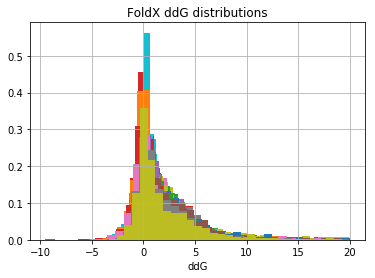

In [109]:
fig = plt.figure() 
for i in list(set(df['PDB']))[1:50]:
    tmp = df[df['PDB'] == i].FX_ddG
    tmp.hist(bins = 30, stacked=False, density=True)
plt.title('FoldX ddG distributions')
plt.xlabel('ddG')
plt.show()

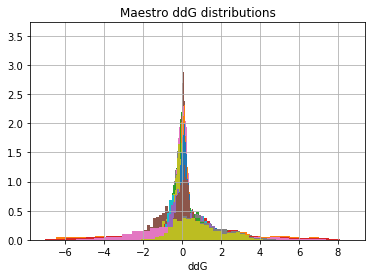

In [110]:
fig = plt.figure()
for i in list(set(df['PDB']))[1:50]:
    tmp = df[df['PDB'] == i].M_ddG
    tmp.hist(bins = 30, stacked=False, density=True)
plt.title('Maestro ddG distributions')
plt.xlabel('ddG')
plt.show()

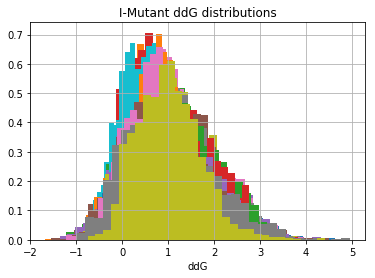

In [111]:
fig = plt.figure()
for i in list(set(df['PDB']))[1:50]:
    tmp = df[df['PDB'] == i].IM_ddG
    tmp.hist(bins = 30, stacked=False, density=True)
plt.title('I-Mutant ddG distributions')
plt.xlabel('ddG')
plt.show()

В статье (doi:10.1016/j.jmb.2007.03.069) говорится, что распределение $ddG$ можно приблизить с помощью суммы двух нормальных распределений. Первое из них имеет меньшее среднее и описывает эффект мутаций аминокислот, находящихся на поверхности глобулы, второе описывает мутации, происходящие внутри глобулы. $P$ - параметр, для каждого белка свой.

$$F_{bi-Gaussian}(x) = \frac{P}{\sqrt{2\pi\sigma_1^2}}\exp[\frac{-(x - \mu_1)^2}{2 \sigma_1^2}] + 
                            \frac{1 - P}{\sqrt{2\pi\sigma_2^2}}\exp[\frac{-(x - \mu_2)^2}{2 \sigma_2^2}]$$

$$\mu_1 = 0.56 \pm 0.12$$

$$\sigma_1 = 0.9 \pm 0.16$$

$$\mu_2 = 1.96 \pm 0.53$$

$$\sigma_2 = 1.93 \pm 0.29$$

In [10]:
# Gaussian parameters

constant = 1
sigma1 = 0.9
mu1 = 0.56
sigma2 = 1.93
mu2 = 1.96

In [11]:
def bi_gaussian(X, P=0.5):
    x = np.array(X)
    a1 = P / math.sqrt(2 * math.pi * sigma1 ** 2)
    a2 = (1 - P) / math.sqrt(2 * math.pi * sigma2 ** 2)
    e1 = np.exp(-np.square(x - mu1)  / (2 * sigma1 ** 2) )
    e2 = np.exp(-np.square(x - mu2) / (2 * sigma2 ** 2) )
    return constant * (a1 * e1 + a2 * e2)

Text(0.5,0,'ddG')

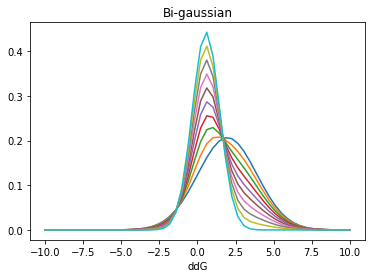

In [12]:
ddG_range = np.linspace(-10, 10, 50)
for p in np.linspace(0, 1, 10):
    plt.plot(ddG_range, bi_gaussian(ddG_range, p))
plt.title('Bi-gaussian')
plt.xlabel('ddG')

In [13]:
def fit_to_bi_gaussian(pdb, program):
    ydata, xdata = np.histogram(df[df['PDB'] == pdb][program +'_ddG'], bins = 50, density=True)
    xdata = np.array([np.mean([xdata[i], xdata[i + 1]]) for i in range(len(xdata) - 1)]) # centers of bins
    popt, pcov = curve_fit(bi_gaussian, xdata, ydata, bounds = [0,1])
    result.loc[pdb, program +'_P'] = popt[0]
    result.loc[pdb, program +'_sigma'] = math.sqrt(pcov[0])
    y_opt = bi_gaussian(xdata, popt[0])
    R, p_val = pearsonr(ydata, y_opt)
    result.loc[pdb, program +'_R'] = R

In [16]:
result = pd.DataFrame(index=list(set(df['PDB'])), columns=['FX_median', 'FX_P', 'FX_sigma', 'FX_R',
                                                           'M_median', 'M_P', 'M_sigma', 'M_R',
                                                           'IM_median', 'IM_P', 'IM_sigma', 'IM_R'])
    
    
for pdb in list(set(df['PDB'])):
    stat = df[df['PDB'] == pdb].describe()
    result.loc[pdb, 'FX_median'] = stat.loc['50%', 'FX_ddG']
    result.loc[pdb, 'M_median'] = stat.loc['50%', 'M_ddG']
    result.loc[pdb, 'IM_median'] = stat.loc['50%', 'IM_ddG']
    
    for program in ['FX', 'M', 'IM']:
        fit_to_bi_gaussian(pdb, program)

In [39]:
for col in result.columns:
    result[col] = pd.to_numeric(result[col], errors='raise')

In [37]:
result.head()

,FX_median,FX_P,FX_sigma,FX_R,M_median,M_P,M_sigma,M_R,IM_median,IM_P,IM_sigma,IM_R
2wc2,0.593613,0.608151,0.051331,0.936309,-0.584177,0.145627,0.106267,0.228036,0.90,0.838357,0.072073,0.872781
3l1e,0.592670,0.759241,0.062389,0.922334,0.290550,0.966779,0.101630,0.792720,0.91,0.936238,0.084345,0.865048
1sce,0.623354,0.639496,0.051075,0.939510,0.683900,0.631808,0.051353,0.868719,0.67,1.000000,0.072390,0.920811
2a1t,1.492405,0.299155,0.026212,0.985148,-0.081539,1.000000,0.335216,0.039235,0.87,1.000000,0.082481,0.882219
1wyi,1.150220,0.406024,0.039589,0.958652,0.071559,1.000000,0.127349,0.660771,0.86,0.905115,0.063614,0.917152


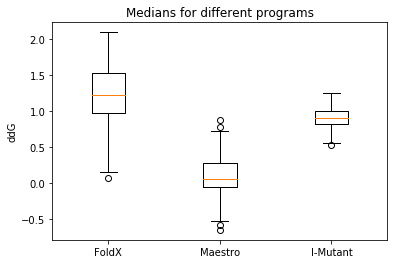

In [112]:
plt.boxplot([result.FX_median, result.M_median, result.IM_median], labels=['FoldX', 'Maestro', 'I-Mutant']);
plt.title('Medians for different programs')
plt.ylabel('ddG');

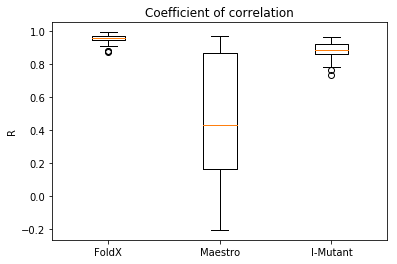

In [45]:
plt.boxplot([result.FX_R, result.M_R, result.IM_R], labels=['FoldX', 'Maestro', 'I-Mutant']);
plt.title('Coefficient of correlation')
plt.ylabel('R');

Получилось, что для FoldX и I-Mutant эта модель более менее подходит, для Maestro - нет. Можно подобрать средние и дисперсии заново для каждой программы.

In [81]:
m_gauss = pd.DataFrame(index=list(set(df['PDB'])), columns=['P', 'mu1', 'mu2', 'sigma1', 'sigma2'])
im_gauss = pd.DataFrame(index=list(set(df['PDB'])), columns=['P', 'mu1', 'mu2', 'sigma1', 'sigma2'])
fx_gauss = pd.DataFrame(index=list(set(df['PDB'])), columns=['P', 'mu1', 'mu2', 'sigma1', 'sigma2'])

In [82]:
def bi_gaussian_param(X, P, mu1, mu2, sigma1, sigma2):
    x = np.array(X)
    a1 = P / math.sqrt(2 * math.pi * sigma1 ** 2)
    a2 = (1 - P) / math.sqrt(2 * math.pi * sigma2 ** 2)
    e1 = np.exp(-np.square(x - mu1)  / (2 * sigma1 ** 2) )
    e2 = np.exp(-np.square(x - mu2) / (2 * sigma2 ** 2) )
    return constant * (a1 * e1 + a2 * e2)

In [89]:
def fit_to_bi_gaussian_param(pdb, data, program):
    ydata, xdata = np.histogram(df[df['PDB'] == pdb][program +'_ddG'], bins = 50, density=True)
    bounds = ([0, -np.inf, -np.inf, -np.inf, -np.inf], [1, np.inf, np.inf, np.inf, np.inf])
    xdata = np.array([np.mean([xdata[i], xdata[i + 1]]) for i in range(len(xdata) - 1)]) # centers of bins
    popt, pcov = curve_fit(bi_gaussian_param, xdata, ydata, p0=[0.5, 0.56, 1.96, 0.9, 1.93],
                           bounds=bounds)
    data.loc[pdb, 'P'] = popt[0]
    data.loc[pdb, 'mu1'] = popt[1]
    data.loc[pdb, 'mu2'] = popt[2]
    data.loc[pdb, 'sigma1'] = popt[3]
    data.loc[pdb, 'sigma2'] = popt[4]
    # maestro_gauss.loc[pdb, program +'_sigma'] = math.sqrt(pcov[0])
    y_opt = bi_gaussian_param(xdata, *popt)
    R, p_val = pearsonr(ydata, y_opt)
    data.loc[pdb, 'R'] = R
    for col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='raise')
    
for pdb in list(set(df['PDB'])):
    fit_to_bi_gaussian_param(pdb, m_gauss, 'M')
    fit_to_bi_gaussian_param(pdb, im_gauss, 'IM')
    fit_to_bi_gaussian_param(pdb, fx_gauss, 'FX')

In [90]:
m_gauss.head()

,P,mu1,mu2,sigma1,sigma2,R
2wc2,0.216459,-0.960946,-0.427907,0.978720,4.304134,0.913644
3l1e,0.466067,-0.009343,0.911780,0.345573,1.162502,0.988782
1sce,0.360669,0.049449,1.461041,0.521667,1.411678,0.957362
2a1t,0.728764,-0.157301,0.167753,0.251680,0.314125,0.991359
1wyi,0.659326,-0.225594,0.915073,0.450361,0.540580,0.986023


In [91]:
im_gauss.head()

,P,mu1,mu2,sigma1,sigma2,R
2wc2,0.864455,0.766763,2.525690,0.684493,0.409966,0.961030
3l1e,0.362201,0.455338,1.291222,0.334202,0.837540,0.970303
1sce,0.538953,0.386716,1.197570,0.441999,0.746378,0.986315
2a1t,0.878116,0.818718,1.414847,0.654725,0.951059,0.985611
1wyi,0.215437,0.265881,1.113778,0.388127,0.807944,0.980424


In [92]:
fx_gauss.head()

,P,mu1,mu2,sigma1,sigma2,R
2wc2,0.492494,0.122946,1.668619,0.737848,2.296880,0.988571
3l1e,0.596688,0.174483,2.456154,0.590912,2.103496,0.992359
1sce,0.449256,0.138212,1.760222,0.569433,1.841763,0.991877
2a1t,0.240096,0.360360,1.937369,0.717268,2.289185,0.990035
1wyi,0.422680,0.200382,2.417726,0.866218,2.519353,0.991048


In [102]:
fx_gauss.describe()

,P,mu1,mu2,sigma1,sigma2,R
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.348879,0.217222,2.134555,0.693165,2.304325,0.991635
std,0.077819,0.128418,0.544577,0.120257,0.237600,0.004191
min,0.196974,-0.084640,0.200863,0.436844,1.379033,0.974927
25%,0.300002,0.128513,1.953708,0.606970,2.202781,0.989887
50%,0.342660,0.202406,2.241686,0.683543,2.323836,0.992359
75%,0.392480,0.310953,2.456154,0.758562,2.437915,0.994461
max,0.596688,0.638271,3.265000,1.048222,3.035747,0.998884


Полученные значения не совпадают с теми, которые были в статье: $\mu_1=0.21$, $\mu_2=2.13$.

In [103]:
m_gauss.describe()

,P,mu1,mu2,sigma1,sigma2,R
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.604010,-0.103788,0.834986,0.414160,0.750860,0.972439
std,0.272656,0.286283,0.928664,0.594178,0.834845,0.048500
min,0.050858,-1.066223,-0.501811,-0.743624,-0.389728,0.623132
25%,0.431275,-0.192537,0.334249,0.223216,0.240069,0.977318
50%,0.586707,-0.035527,0.749333,0.327114,0.540580,0.984227
75%,0.870893,0.066367,1.063309,0.480952,1.027748,0.987905
max,0.995905,0.387421,6.667770,3.519919,4.304134,0.993026


In [104]:
im_gauss.describe()

,P,mu1,mu2,sigma1,sigma2,R
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,0.497455,0.575586,1.420748,0.509052,0.691209,0.981007
std,0.279180,0.325927,0.546069,0.183047,0.183917,0.008939
min,0.051950,-0.000971,-0.126118,-0.321127,0.190496,0.939833
25%,0.272022,0.335893,1.061373,0.390455,0.567927,0.977762
50%,0.500919,0.565320,1.358052,0.554589,0.746006,0.982874
75%,0.764001,0.753998,1.833259,0.633560,0.822278,0.987127
max,0.981543,1.968346,2.547648,0.899043,1.043632,0.993491


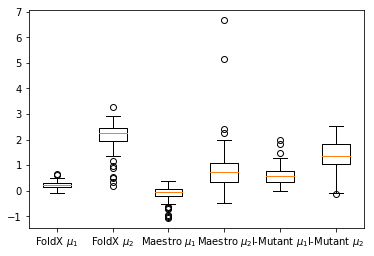

In [101]:
plt.boxplot([fx_gauss.mu1, fx_gauss.mu2, m_gauss.mu1, m_gauss.mu2, im_gauss.mu1, im_gauss.mu2],
           labels=["FoldX $\mu_1$", "FoldX $\mu_2$", "Maestro $\mu_1$", "Maestro $\mu_2$", "I-Mutant $\mu_1$", "I-Mutant $\mu_2$"]);

#### ddG из статьи с deep mutational scanning (immunoglobulin binding protein)

In [118]:
gb1 = pd.read_csv('GB1_699_dataset_values.csv')
gb1['ddG'] = gb1['ddGexp']
gb1.drop(columns='ddGexp', inplace=True)

In [119]:
gb1.head()

,PDB,MUTATION,MUTATED_CHAIN,pos,aa1,aa2,M_ddG,IM_ddG,FX_ddG,ddG
0,1pga,T 2 A,A,2,T,A,0.655059,0.53,0.498797,2.755
1,1pga,T 2 C,A,2,T,C,0.132381,0.54,0.274565,2.793
2,1pga,T 2 D,A,2,T,D,0.315382,0.68,0.301895,3.436
3,1pga,T 2 E,A,2,T,E,-0.097342,0.60,0.223198,1.923
4,1pga,T 2 F,A,2,T,F,-0.269423,0.14,-0.299334,-0.171


In [136]:
gb1[['M_ddG', 'IM_ddG', 'FX_ddG', 'ddG']].describe()

,M_ddG,IM_ddG,FX_ddG,ddG
count,699,699,699,699
mean,0.178684,0.259628,0.797296,1.93735
std,0.947213,0.565257,1.88533,1.47131
min,-1.53348,-1.4,-1.97922,-1.864
25%,-0.502135,-0.12,-0.199998,0.9445
50%,-0.01321,0.25,0.332923,1.707
75%,0.64877,0.63,1.16227,2.8815
max,4.09521,2.35,19.0695,6.402


In [134]:
gb1[['M_ddG', 'IM_ddG', 'FX_ddG', 'ddG']].corr()

,M_ddG,IM_ddG,FX_ddG,ddG
M_ddG,1.000000,0.432604,0.377294,0.602912
IM_ddG,0.432604,1.000000,0.197329,0.367197
FX_ddG,0.377294,0.197329,1.000000,0.428448
ddG,0.602912,0.367197,0.428448,1.000000


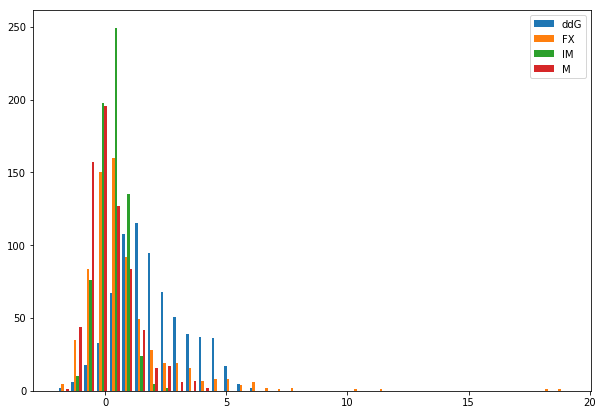

In [132]:
plt.figure(figsize=(10, 7))
plt.hist([gb1.ddG, gb1.FX_ddG, gb1.IM_ddG, gb1.M_ddG,], label=['ddG', 'FX', 'IM', 'M'], bins=40);
plt.legend()